In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from scipy.stats import entropy
import warnings
import os
import sys

# 忽略警告
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据

In [24]:
dataset_name = "PEMS03"
# PEMS03: 2018/09/01 -> 2018/11/30

# 加载节点信息
nodes_df = pd.read_csv(f'{dataset_name}.txt', header=None, names=['node_id'])
print(f"节点数量: {len(nodes_df)}")

# 加载距离矩阵
distance_df = pd.read_csv(f'{dataset_name}.csv')
print(f"距离关系数量: {len(distance_df)}")

# 加载原始数据
raw_df = pd.read_csv(f'{dataset_name}_raw.csv')
print(f"原始数据关系数量: {len(raw_df)}")

# 加载numpy数据
traffic_data = None
try:
    data_npz = np.load(f'{dataset_name}.npz')
    print(f"NPZ文件中的数组: {list(data_npz.keys())}")
    for key in data_npz.keys():
        print(f"  {key}: {data_npz[key].shape}")

    if 'data' in data_npz:
        traffic_data = data_npz['data']
        print(f"交通流量数据形状: {traffic_data.shape}")
except Exception as e:
    print(f"无法加载NPZ文件: {e}")

节点数量: 358
距离关系数量: 547
原始数据关系数量: 547
NPZ文件中的数组: ['data']
  data: (26208, 358, 1)
交通流量数据形状: (26208, 358, 1)


# 分析距离分布

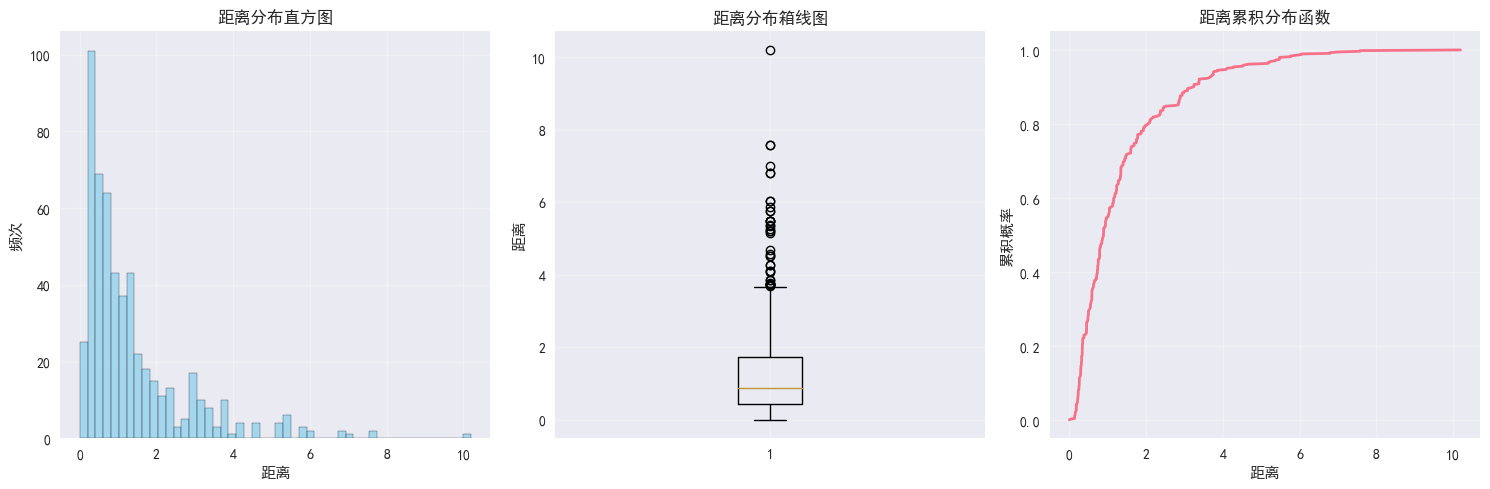

距离统计信息:
平均距离: 1.367
中位数距离: 0.888
标准差: 1.386
最小距离: 0.000
最大距离: 10.194


In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 距离直方图
axes[0].hist(distance_df['distance'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('距离分布直方图')
axes[0].set_xlabel('距离')
axes[0].set_ylabel('频次')
axes[0].grid(True, alpha=0.3)

# 距离箱线图
axes[1].boxplot(distance_df['distance'])
axes[1].set_title('距离分布箱线图')
axes[1].set_ylabel('距离')
axes[1].grid(True, alpha=0.3)

# 距离累积分布
sorted_distances = np.sort(distance_df['distance'])
cumulative_prob = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
axes[2].plot(sorted_distances, cumulative_prob, linewidth=2)
axes[2].set_title('距离累积分布函数')
axes[2].set_xlabel('距离')
axes[2].set_ylabel('累积概率')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 距离统计信息
print("距离统计信息:")
print(f"平均距离: {distance_df['distance'].mean():.3f}")
print(f"中位数距离: {distance_df['distance'].median():.3f}")
print(f"标准差: {distance_df['distance'].std():.3f}")
print(f"最小距离: {distance_df['distance'].min():.3f}")
print(f"最大距离: {distance_df['distance'].max():.3f}")

# 分析网络结构

网络节点数: 358
网络边数: 547
网络密度: 0.0086
连通分量数量: 8
最大连通分量大小: 110
平均度: 3.06
最大度: 6
最小度: 1


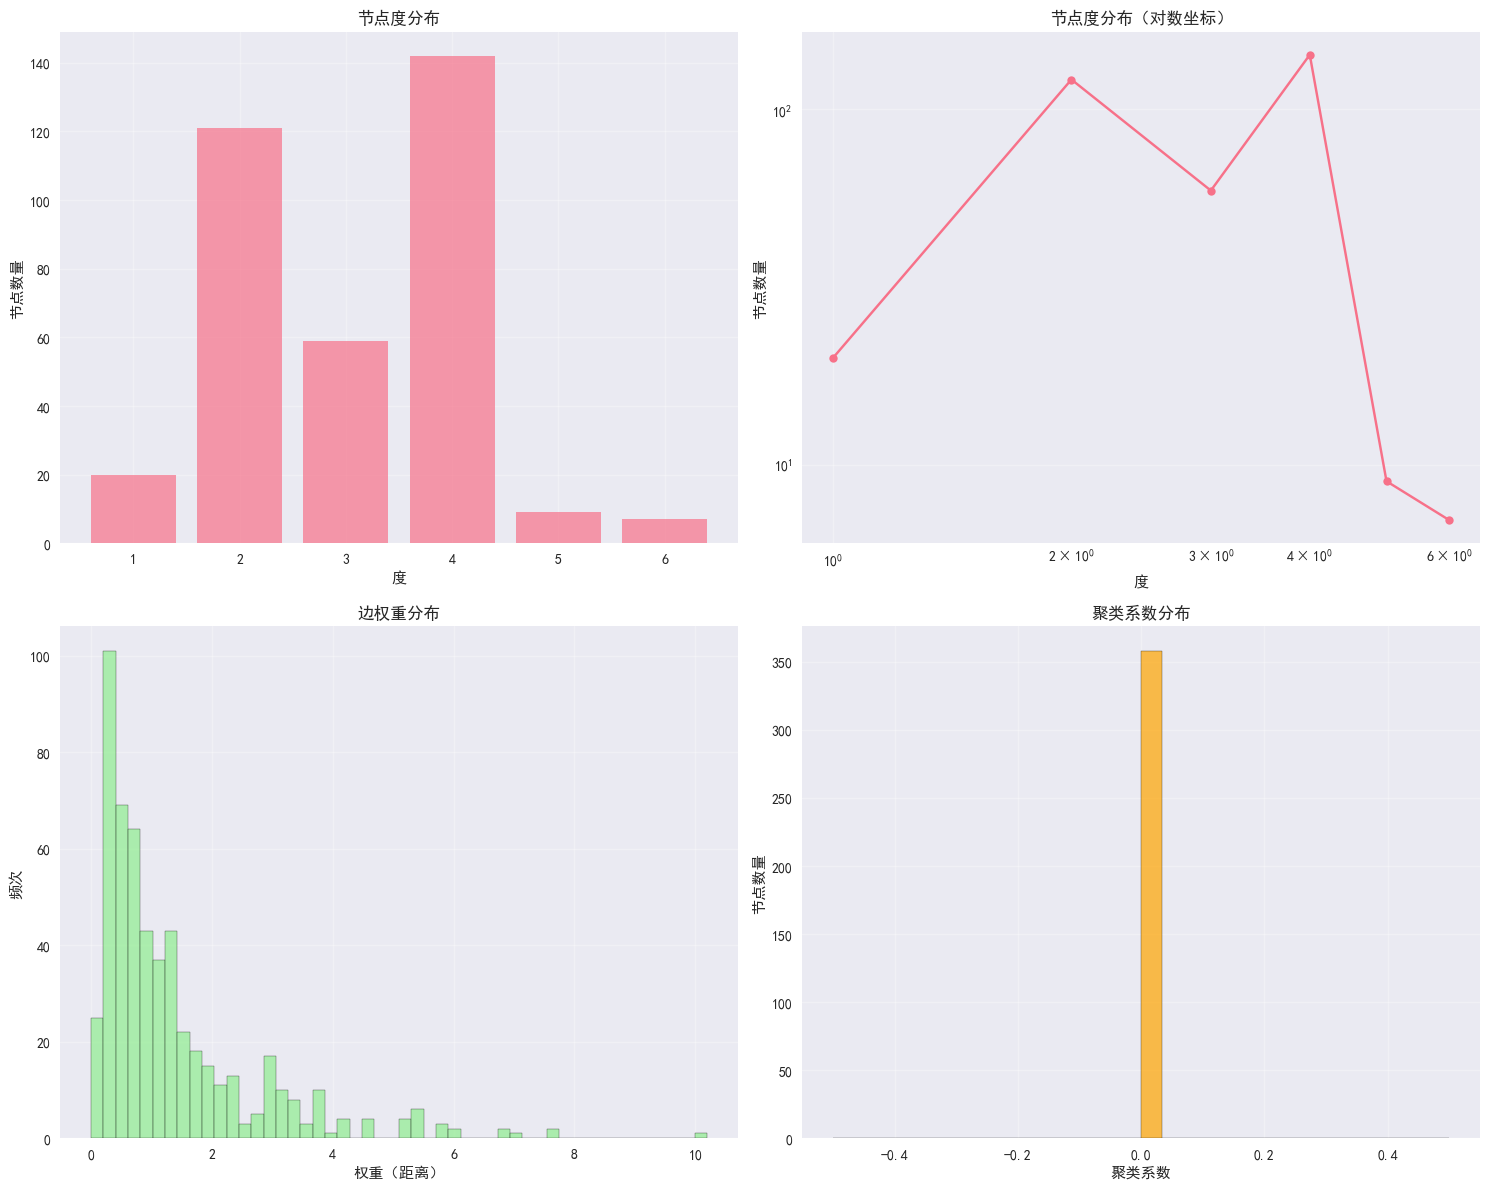

平均聚类系数: 0.0000
全局聚类系数: 0.0000


In [26]:
# 构建网络图
G = nx.Graph()

# 添加边
for _, row in distance_df.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['distance'])

print(f"网络节点数: {G.number_of_nodes()}")
print(f"网络边数: {G.number_of_edges()}")
print(f"网络密度: {nx.density(G):.4f}")

# 计算连通分量
connected_components = list(nx.connected_components(G))
print(f"连通分量数量: {len(connected_components)}")
print(f"最大连通分量大小: {len(max(connected_components, key=len))}")

# 计算度分布
degrees = [d for n, d in G.degree()]
print(f"平均度: {np.mean(degrees):.2f}")
print(f"最大度: {max(degrees)}")
print(f"最小度: {min(degrees)}")

# 网络结构可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 度分布
degree_counts = pd.Series(degrees).value_counts().sort_index()
axes[0, 0].bar(degree_counts.index, degree_counts.values, alpha=0.7)
axes[0, 0].set_title('节点度分布')
axes[0, 0].set_xlabel('度')
axes[0, 0].set_ylabel('节点数量')
axes[0, 0].grid(True, alpha=0.3)

# 度分布（对数坐标）
axes[0, 1].loglog(degree_counts.index, degree_counts.values, 'o-', markersize=6)
axes[0, 1].set_title('节点度分布（对数坐标）')
axes[0, 1].set_xlabel('度')
axes[0, 1].set_ylabel('节点数量')
axes[0, 1].grid(True, alpha=0.3)

# 边权重分布
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
axes[1, 0].hist(edge_weights, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('边权重分布')
axes[1, 0].set_xlabel('权重（距离）')
axes[1, 0].set_ylabel('频次')
axes[1, 0].grid(True, alpha=0.3)

# 聚类系数分布
clustering_coeffs = nx.clustering(G)
coeff_values = list(clustering_coeffs.values())
axes[1, 1].hist(coeff_values, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_title('聚类系数分布')
axes[1, 1].set_xlabel('聚类系数')
axes[1, 1].set_ylabel('节点数量')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"平均聚类系数: {np.mean(coeff_values):.4f}")
print(f"全局聚类系数: {nx.average_clustering(G):.4f}")

# 分析交通流量数据

数据统计信息:
时间步数: 26208
节点数: 358
特征数: 1

数值统计:
平均值: 179.26
标准差: 143.71
最小值: 0.00
最大值: 1852.00
中位数: 136.00

缺失值数量: 0
缺失值比例: 0.00%


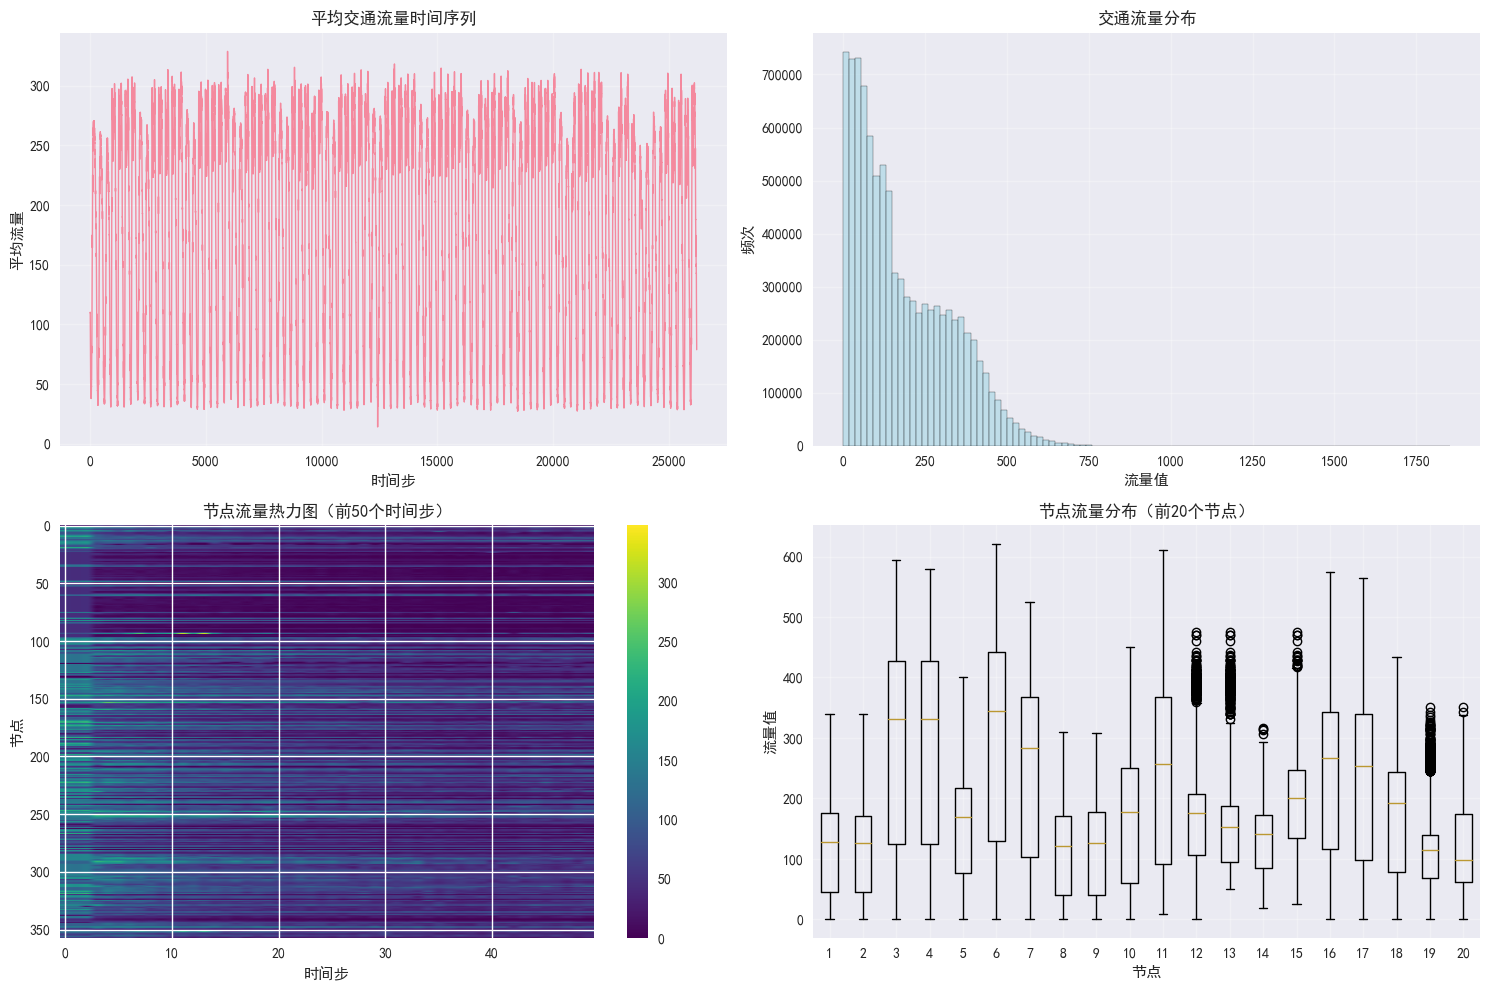

In [27]:
# 基本统计信息
print("数据统计信息:")
print(f"时间步数: {traffic_data.shape[0]}")
print(f"节点数: {traffic_data.shape[1]}")
print(f"特征数: {traffic_data.shape[2] if len(traffic_data.shape) > 2 else 1}")

# 数据统计
print("\n数值统计:")
print(f"平均值: {np.mean(traffic_data):.2f}")
print(f"标准差: {np.std(traffic_data):.2f}")
print(f"最小值: {np.min(traffic_data):.2f}")
print(f"最大值: {np.max(traffic_data):.2f}")
print(f"中位数: {np.median(traffic_data):.2f}")

# 检查缺失值
missing_count = np.sum(np.isnan(traffic_data))
print(f"\n缺失值数量: {missing_count}")
print(f"缺失值比例: {missing_count/traffic_data.size*100:.2f}%")

# 时间序列可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 整体时间序列趋势
mean_traffic = np.mean(traffic_data, axis=(1, 2) if len(traffic_data.shape) > 2 else 1)
axes[0, 0].plot(mean_traffic, linewidth=1, alpha=0.8)
axes[0, 0].set_title('平均交通流量时间序列')
axes[0, 0].set_xlabel('时间步')
axes[0, 0].set_ylabel('平均流量')
axes[0, 0].grid(True, alpha=0.3)

# 流量分布直方图
axes[0, 1].hist(traffic_data.flatten(), bins=100, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 1].set_title('交通流量分布')
axes[0, 1].set_xlabel('流量值')
axes[0, 1].set_ylabel('频次')
axes[0, 1].grid(True, alpha=0.3)

# 节点流量热力图（前50个时间步）
if len(traffic_data.shape) > 2:
    sample_data = traffic_data[:50, :, 0]  # 取前50个时间步，第一个特征
else:
    sample_data = traffic_data[:50, :]

im = axes[1, 0].imshow(sample_data.T, aspect='auto', cmap='viridis')
axes[1, 0].set_title('节点流量热力图（前50个时间步）')
axes[1, 0].set_xlabel('时间步')
axes[1, 0].set_ylabel('节点')
plt.colorbar(im, ax=axes[1, 0])

# 流量箱线图（按节点）
if len(traffic_data.shape) > 2:
    node_means = np.mean(traffic_data, axis=(0, 2))
else:
    node_means = np.mean(traffic_data, axis=0)

axes[1, 1].boxplot([traffic_data[:, i].flatten() for i in range(min(20, traffic_data.shape[1]))])
axes[1, 1].set_title('节点流量分布（前20个节点）')
axes[1, 1].set_xlabel('节点')
axes[1, 1].set_ylabel('流量值')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 分析空间相关性

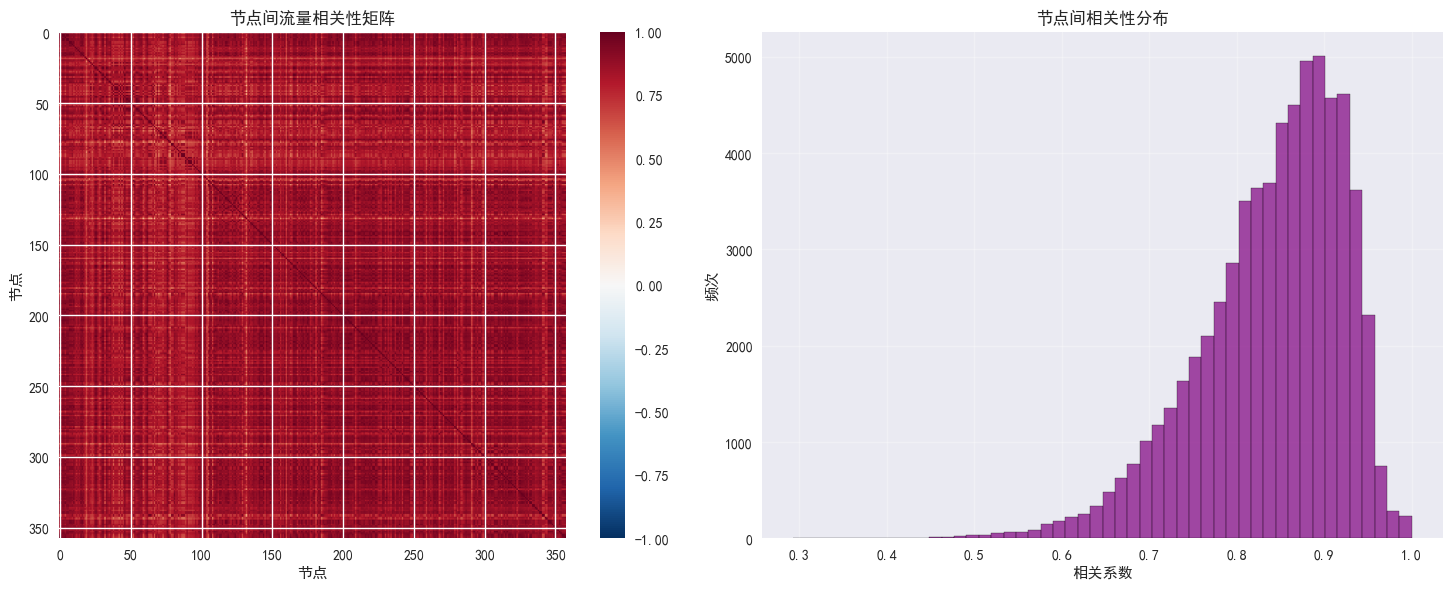

平均相关性: 0.8400
相关性标准差: 0.0829
强正相关比例 (>0.7): 93.39%
强负相关比例 (<-0.7): 0.00%


In [28]:
 # 计算节点间的相关性矩阵
if len(traffic_data.shape) > 2:
    # 如果是3D数据，取第一个特征
    traffic_2d = traffic_data[:, :, 0]
else:
    traffic_2d = traffic_data

# 计算相关性矩阵
corr_matrix = np.corrcoef(traffic_2d.T)

# 可视化相关性矩阵
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 相关性热力图
im1 = axes[0].imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
axes[0].set_title("节点间流量相关性矩阵")
axes[0].set_xlabel("节点")
axes[0].set_ylabel("节点")
plt.colorbar(im1, ax=axes[0])

# 相关性分布直方图
# 只取上三角矩阵的值（避免重复）
upper_tri = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
axes[1].hist(upper_tri, bins=50, alpha=0.7, color="purple", edgecolor="black")
axes[1].set_title("节点间相关性分布")
axes[1].set_xlabel("相关系数")
axes[1].set_ylabel("频次")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("spatial_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"平均相关性: {np.mean(upper_tri):.4f}")
print(f"相关性标准差: {np.std(upper_tri):.4f}")
print(f"强正相关比例 (>0.7): {np.sum(upper_tri > 0.7) / len(upper_tri) * 100:.2f}%")
print(f"强负相关比例 (<-0.7): {np.sum(upper_tri < -0.7) / len(upper_tri) * 100:.2f}%")